<a href="https://colab.research.google.com/github/Ajwad07/ML_projects_/blob/main/AE_Cifar10_conv_layer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader



In [3]:
# 1. Data transforms for CIFAR-10 (normalize to [0,1] or [-1,1])
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



In [4]:
# 2. Load CIFAR-10
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)



100%|██████████| 170M/170M [00:48<00:00, 3.48MB/s]


In [5]:
len(test_dataset)

10000

In [6]:
# 3. Define an Autoencoder for CIFAR-10
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),   # (batch, 3, 32, 32) -> (batch, 16, 16, 16)
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (batch, 16, 16, 16) -> (batch, 32, 8, 8)
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (batch, 32, 8, 8) -> (batch, 64, 4, 4)
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),  # (batch, 64, 4, 4) -> (batch, 32, 8, 8)
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  # (batch, 32, 8, 8) -> (batch, 16, 16, 16)
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),   # (batch, 16, 16, 16) -> (batch, 3, 32, 32)
            nn.Tanh()  # Because normalized to [-1, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder().cuda() if torch.cuda.is_available() else ConvAutoencoder()



Epoch:1, Loss:0.18591392040252686
Epoch:2, Loss:0.10672782361507416
Epoch:3, Loss:0.07443112134933472
Epoch:4, Loss:0.06376664340496063
Epoch:5, Loss:0.057146236300468445
Epoch:6, Loss:0.05169986933469772
Epoch:7, Loss:0.0467412993311882
Epoch:8, Loss:0.04168842360377312
Epoch:9, Loss:0.035414308309555054
Epoch:10, Loss:0.0320509672164917
Epoch:11, Loss:0.0297986026853323
Epoch:12, Loss:0.028231730684638023
Epoch:13, Loss:0.026895128190517426
Epoch:14, Loss:0.02575976774096489
Epoch:15, Loss:0.024823134765028954
Epoch:16, Loss:0.02402135729789734
Epoch:17, Loss:0.023463165387511253
Epoch:18, Loss:0.022831087931990623
Epoch:19, Loss:0.022266685962677002
Epoch:20, Loss:0.021776115521788597


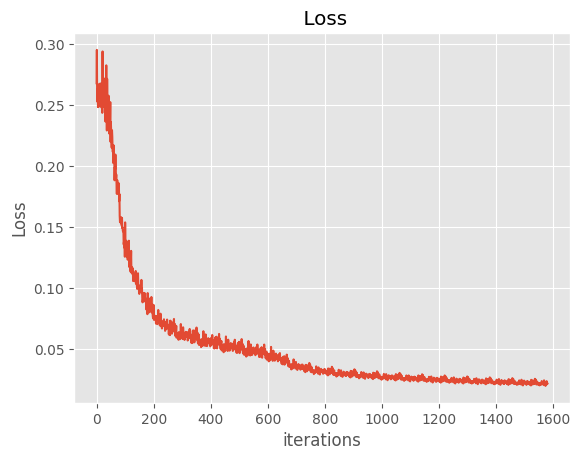

In [7]:
# 4. Loss and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002,weight_decay=1e-9)

op=[]
losses=[]

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

# 5. Training loop (simplified)
num_epochs = 20
for epoch in range(num_epochs):
    for data in test_loader:
        imgs, _ = data
        imgs = imgs.cuda() if torch.cuda.is_available() else imgs #images=images.view(-1,28*28*1).to(device) -> needs when the model has no flatten and -1 refers to batch size <----> refer to 1st layer of enocder
        # Forward
        outputs = model(imgs)
        loss = loss_fn(outputs, imgs)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        op.append((epoch,imgs,outputs))
    print(f"Epoch:{epoch+1}, Loss:{loss.item()}")

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(losses)
plt.title(" Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

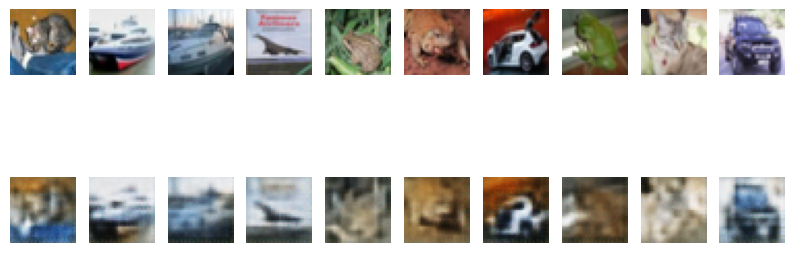

In [11]:
model.eval()
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)
reconstructed = model(images)

# Denormalize for display
images_show = (images.cpu().detach().numpy() + 1) / 2
reconstructed_show = (reconstructed.cpu().detach().numpy() + 1) / 2

fig, axes = plt.subplots(2, 10, figsize=(10, 4))
for i in range(10):
    axes[0, i].imshow(images_show[i].transpose(1, 2, 0))
    axes[0, i].axis('off')
    axes[1, i].imshow(reconstructed_show[i].transpose(1, 2, 0))
    axes[1, i].axis('off')
plt.show()